***3. LightGBM***

À RISQUE:    326 (60.7%)
SOUTENABLE:  211 (39.3%)
À RISQUE:    64 (53.3%)
SOUTENABLE:  56 (46.7%)

 Shift réduit: 7.4% (vs 21-24% en multiclasse)
scale_pos_weight: 0.65
Modèle entraîné (200 arbres)
              precision    recall  f1-score   support

  SOUTENABLE      0.894     0.924     0.909       211
    À RISQUE      0.950     0.929     0.940       326

    accuracy                          0.927       537
   macro avg      0.922     0.927     0.924       537
weighted avg      0.928     0.927     0.928       537

              precision    recall  f1-score   support

  SOUTENABLE      0.667     0.714     0.690        56
    À RISQUE      0.733     0.688     0.710        64

    accuracy                          0.700       120
   macro avg      0.700     0.701     0.700       120
weighted avg      0.702     0.700     0.700       120

F1 Train:       0.9395
F1 Test:        0.7097
Gap:            0.2299Overfitting persistant
Vrais Positifs (À RISQUE détecté):  44
Faux Négatifs (À R

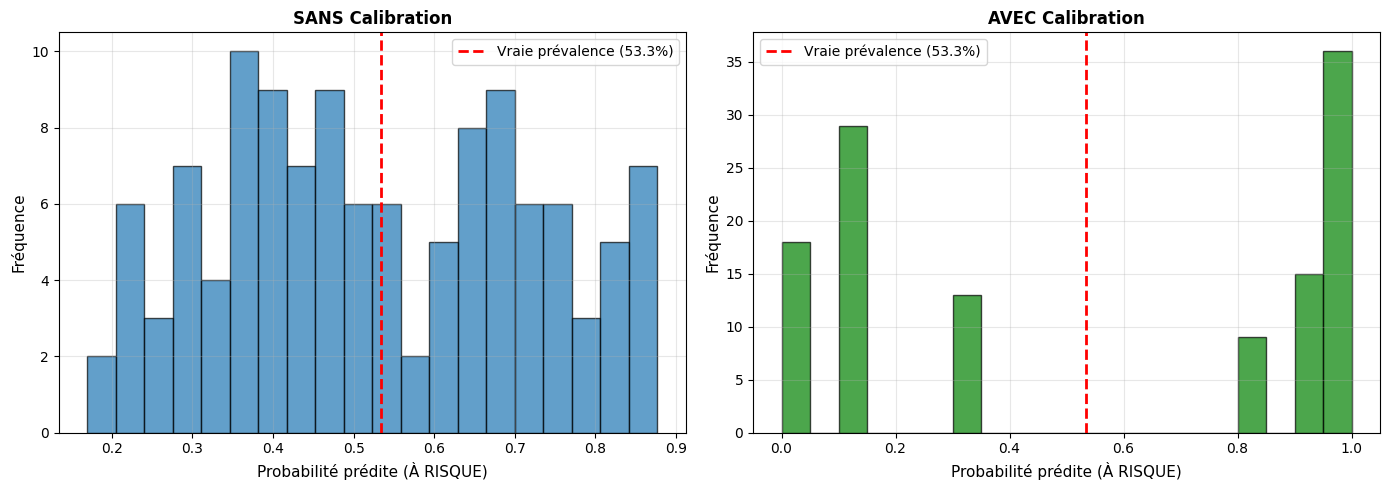


 Seuil optimal: 0.20
F1 au seuil ~0.50: 0.7097
F1 au seuil 0.20: 0.7299
Gain:             +0.0202


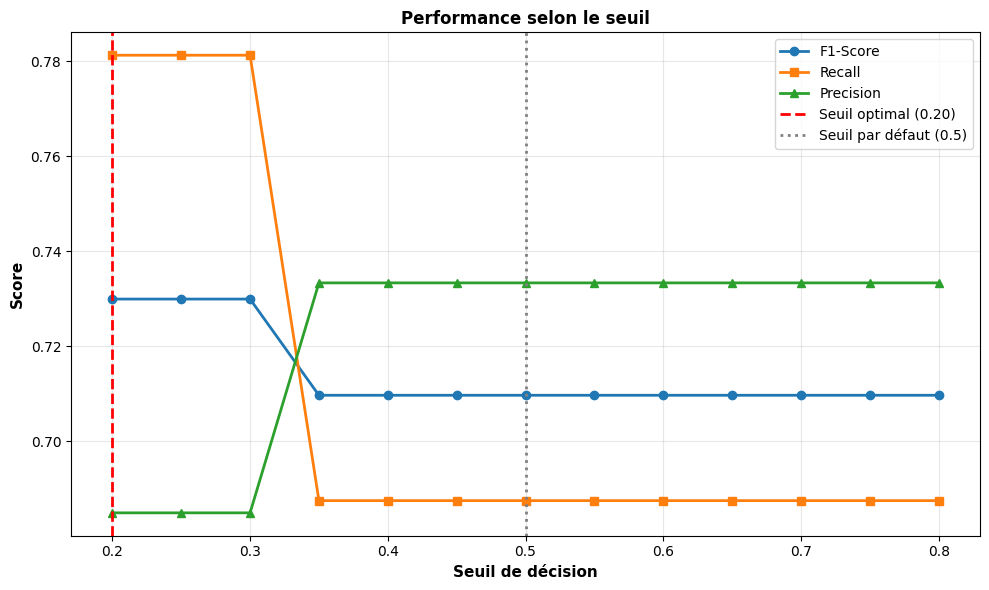


 PERFORMANCE FINALE (seuil = 0.20):
              precision    recall  f1-score   support

  SOUTENABLE      0.702     0.589     0.641        56
    À RISQUE      0.685     0.781     0.730        64

    accuracy                          0.692       120
   macro avg      0.694     0.685     0.685       120
weighted avg      0.693     0.692     0.688       120

              feature  importance
Corruption_Governance         145
    External_Debt_GDP         121
 Debt_Service_Exports         114
     Net_ODA_received          99
        Exchange_Rate          87
           GDP_Growth          65
      Current_Account          45

   F1-Score Test:     0.7097
   Recall À RISQUE:   68.8%
   Gap Train-Test:    0.2299


In [ ]:
distress_label = label_encoder.transform(['DISTRESS'])[0]
high_label = label_encoder.transform(['HIGH'])[0]

y_train_binary = ((y_train_final == distress_label) |
                  (y_train_final == high_label)).astype(int)
y_test_binary = ((y_test_final == distress_label) |
                 (y_test_final == high_label)).astype(int)


print(f"À RISQUE:    {y_train_binary.sum()} ({y_train_binary.mean():.1%})")
print(f"SOUTENABLE:  {(~y_train_binary.astype(bool)).sum()} ({(~y_train_binary.astype(bool)).mean():.1%})")

print(f"À RISQUE:    {y_test_binary.sum()} ({y_test_binary.mean():.1%})")
print(f"SOUTENABLE:  {(~y_test_binary.astype(bool)).sum()} ({(~y_test_binary.astype(bool)).mean():.1%})")

shift_binary = abs(y_train_binary.mean() - y_test_binary.mean()) * 100
print(f"\n Shift réduit: {shift_binary:.1f}% (vs 21-24% en multiclasse)")


n_neg = (~y_train_binary.astype(bool)).sum()
n_pos = y_train_binary.sum()
scale_pos_weight = n_neg / n_pos

print(f"scale_pos_weight: {scale_pos_weight:.2f}")

lgbm_binary = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    verbosity=-1,
    random_state=42,
    n_jobs=-1,
    num_leaves=15,
    max_depth=3,
    min_child_samples=20,
    min_child_weight=1.0,
    lambda_l1=1.0,
    lambda_l2=10.0,
    min_gain_to_split=0.5,
    bagging_fraction=0.56,
    bagging_freq=1,
    feature_fraction=0.6,
    learning_rate=0.02,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight,
    max_bin=63
)

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_final, y_train_binary,
    test_size=0.25, random_state=42, stratify=y_train_binary
)

lgbm_binary.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    callbacks=[
        lgb.early_stopping(stopping_rounds=15, verbose=False),
        lgb.log_evaluation(period=0)
    ]
)

print(f"Modèle entraîné ({lgbm_binary.best_iteration_} arbres)")


calibrated_model = CalibratedClassifierCV(
    lgbm_binary,
    method='isotonic',
    cv='prefit'
)

calibrated_model.fit(X_val, y_val)


y_train_pred_binary = calibrated_model.predict(X_train_final)
y_test_pred_binary = calibrated_model.predict(X_test_final)
y_test_proba_binary = calibrated_model.predict_proba(X_test_final)[:, 1]


print(classification_report(y_train_binary, y_train_pred_binary,
                          target_names=['SOUTENABLE', 'À RISQUE'], digits=3))


print(classification_report(y_test_binary, y_test_pred_binary,
                          target_names=['SOUTENABLE', 'À RISQUE'], digits=3))

train_f1 = f1_score(y_train_binary, y_train_pred_binary)
test_f1 = f1_score(y_test_binary, y_test_pred_binary)
gap = train_f1 - test_f1

print(f"F1 Train:       {train_f1:.4f}")
print(f"F1 Test:        {test_f1:.4f}")
print(f"Gap:            {gap:.4f}", end="")

if gap < 0.10:
    print("Excellent")
elif gap < 0.20:
    print("Acceptable")
else:
    print("Overfitting persistant")

cm = confusion_matrix(y_test_binary, y_test_pred_binary)
tn, fp, fn, tp = cm.ravel()

print(f"Vrais Positifs (À RISQUE détecté):  {tp}")
print(f"Faux Négatifs (À RISQUE raté):      {fn}")
print(f"Faux Positifs (Fausse alerte):      {fp}")
print(f"Vrais Négatifs (SOUTENABLE ok):     {tn}")

recall_at_risk = tp / (tp + fn) if (tp + fn) > 0 else 0
precision_at_risk = tp / (tp + fp) if (tp + fp) > 0 else 0

print(f"Recall:    {recall_at_risk:.1%} (% de crises détectées)")
print(f"Precision: {precision_at_risk:.1%} (% d'alertes correctes)")

if recall_at_risk >= 0.70:
    print("Bonne détection des crises")
elif recall_at_risk >= 0.60:
    print("Détection acceptable mais perfectible")
else:
    print("Trop de crises ratées")


y_test_pred_uncalib = lgbm_binary.predict(X_test_final)
y_test_proba_uncalib = lgbm_binary.predict_proba(X_test_final)[:, 1]

f1_uncalib = f1_score(y_test_binary, y_test_pred_uncalib)
f1_calib = f1_score(y_test_binary, y_test_pred_binary)

print(f"Sans calibration: {f1_uncalib:.4f}")
print(f"Avec calibration: {f1_calib:.4f}")
print(f"Gain:             {f1_calib - f1_uncalib:+.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_test_proba_uncalib, bins=20, alpha=0.7, edgecolor='black')
axes[0].axvline(y_test_binary.mean(), color='red', linestyle='--',
                linewidth=2, label=f'Vraie prévalence ({y_test_binary.mean():.1%})')
axes[0].set_xlabel('Probabilité prédite (À RISQUE)', fontsize=11)
axes[0].set_ylabel('Fréquence', fontsize=11)
axes[0].set_title('SANS Calibration', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(y_test_proba_binary, bins=20, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(y_test_binary.mean(), color='red', linestyle='--',
                linewidth=2, label=f'Vraie prévalence ({y_test_binary.mean():.1%})')
axes[1].set_xlabel('Probabilité prédite (À RISQUE)', fontsize=11)
axes[1].set_ylabel('Fréquence', fontsize=11)
axes[1].set_title('AVEC Calibration', fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


thresholds_to_test = np.arange(0.2, 0.8, 0.05)
results = []

for threshold in thresholds_to_test:
    y_pred_thresh = (y_test_proba_binary >= threshold).astype(int)

    precision = precision_score(y_test_binary, y_pred_thresh) if y_pred_thresh.sum() > 0 else 0
    recall = recall_score(y_test_binary, y_pred_thresh)
    f1 = f1_score(y_test_binary, y_pred_thresh)

    results.append({
        'Seuil': threshold,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

results_df = pd.DataFrame(results)
best_threshold = results_df.loc[results_df['F1'].idxmax(), 'Seuil']

print(f"\n Seuil optimal: {best_threshold:.2f}")

seuil_050 = results_df.iloc[(results_df['Seuil'] - 0.50).abs().argsort()[:1]]
f1_at_050 = seuil_050['F1'].values[0] if len(seuil_050) > 0 else 0

print(f"F1 au seuil ~0.50: {f1_at_050:.4f}")
print(f"F1 au seuil {best_threshold:.2f}: {results_df['F1'].max():.4f}")
print(f"Gain:             {results_df['F1'].max() - f1_at_050:+.4f}")

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results_df['Seuil'], results_df['F1'], 'o-', label='F1-Score', linewidth=2)
ax.plot(results_df['Seuil'], results_df['Recall'], 's-', label='Recall', linewidth=2)
ax.plot(results_df['Seuil'], results_df['Precision'], '^-', label='Precision', linewidth=2)
ax.axvline(best_threshold, color='red', linestyle='--',
           label=f'Seuil optimal ({best_threshold:.2f})', linewidth=2)
ax.axvline(0.5, color='gray', linestyle=':', label='Seuil par défaut (0.5)', linewidth=2)
ax.set_xlabel('Seuil de décision', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11, fontweight='bold')
ax.set_title('Performance selon le seuil', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

y_test_pred_optimal = (y_test_proba_binary >= best_threshold).astype(int)

print(f"\n PERFORMANCE FINALE (seuil = {best_threshold:.2f}):")
print(classification_report(y_test_binary, y_test_pred_optimal,
                          target_names=['SOUTENABLE', 'À RISQUE'], digits=3))


feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm_binary.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.to_string(index=False))


joblib.dump(calibrated_model, 'lgbm_binary_calibrated.pkl')
joblib.dump(best_threshold, 'lgbm_optimal_threshold.pkl')
joblib.dump({
    'train_f1': train_f1,
    'test_f1': test_f1,
    'gap': gap,
    'recall_at_risk': recall_at_risk,
    'best_threshold': best_threshold
}, 'lgbm_binary_metrics.pkl')



print(f"""
   F1-Score Test:     {test_f1:.4f}
   Recall À RISQUE:   {recall_at_risk:.1%}
   Gap Train-Test:    {gap:.4f}""")